# Part 3 - ANalysis Of VAriance (ANOVA)

In this section, we will move beyond comparing two groups, and explore methods to compare *more than two groups* using Analysis of Variance (ANOVA). ANOVA helps us understand if there are significant differences between the means of multiple groups. Specifically, we will:

* Understand the purpose of ANOVA and its assumptions
* Visualize data across multiple groups
* Perform one-way ANOVA using Python to compare penguin body mass across species and sexes
* Interpret ANOVA results and checking post-hoc comparisons

### Understanding ANOVA

ANOVA, or Analysis of Variance, is a statistical method used to test if there are statistically significant differences between the means of two or more groups. For example, we could use ANOVA to test whether there are differences in body mass between different penguin species and different sexes.

The hypotheses in ANOVA are:

* Null Hypothesis (H₀): All group means are equal (no significant difference between the groups).
* Alternative Hypothesis (H₁): At least one group mean is different.

ANOVA itself will not reveal *which* groups are different from each other. To elucidate that, there are different methods, and we will look at one of them, called the Tukey's HSD (honestly significant difference) test, which does pairwise comparisons for all the groups.

**Key assumptions of ANOVA**:
1. Independence: Each entry in the dataset should be independent from the others.
2. Normality: The data within each group should follow a normal distribution.
3. Homogeneity of variances: The variance within each group should be similar (homoscedasticity).

When these assumptions are met, ANOVA is a powerful tool for analyzing group differences. If the assumptions are violated, alternative tests like the Kruskal-Wallis test (which is an extension of the Mann-Whitney U test used in part 1) can be used.

## Loading necessary libraries and data

In [1]:
from pylab import *
import pandas
import scipy.stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Data loading and cleaning

We will first load the data from the penguin survey from the CSV file into a pandas dataframe and remove NaN entries.

In [2]:
penguins=pandas.read_csv('penguins.csv').dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


## Exploratory data analysis

Before running the ANOVA, let's visualize the body mass data for the different penguin species divided by sex to get an initial understanding of the group differences.

In [14]:
penguins.groupby(['species','sex'])['body_mass_g'].describe()

count         mean         std     min      25%     50%  \
species   sex                                                               
Adelie    FEMALE   73.0  3368.835616  269.380102  2850.0  3175.00  3400.0   
          MALE     73.0  4043.493151  346.811553  3325.0  3800.00  4000.0   
Chinstrap FEMALE   34.0  3527.205882  285.333912  2700.0  3362.50  3550.0   
          MALE     34.0  3938.970588  362.137550  3250.0  3731.25  3950.0   
Gentoo    FEMALE   58.0  4679.741379  281.578294  3950.0  4462.50  4700.0   
          MALE     61.0  5484.836066  313.158596  4750.0  5300.00  5500.0   

                      75%     max  
species   sex                      
Adelie    FEMALE  3550.00  3900.0  
          MALE    4300.00  4775.0  
Chinstrap FEMALE  3693.75  4150.0  
          MALE    4100.00  4800.0  
Gentoo    FEMALE  4875.00  5200.0  
          MALE    5700.00  6300.0

The last 5 columns of this table can be represented as a boxplot.

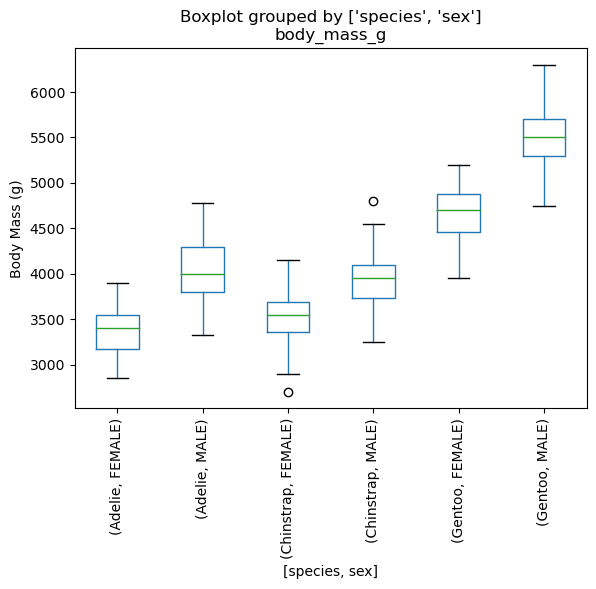

In [15]:
penguins.boxplot(column=['body_mass_g'],by=['species','sex'],grid=False)
ylabel('Body Mass (g)')
xticks(rotation=90)
show()

We will further inspect the distributions by plotting the histograms.

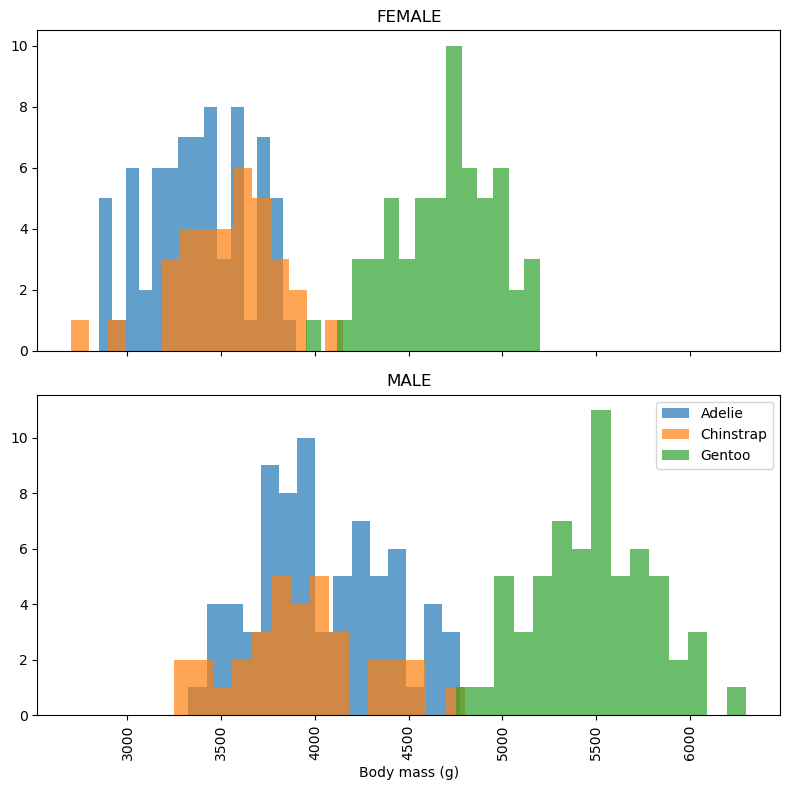

In [4]:
fig,axs=subplots(2,1,sharex=True)
fig.set_size_inches(8,8)
penguins.groupby('species').hist(column=['body_mass_g'],by='sex',ax=axs,grid=False,bins=15,alpha=0.7)
legend(penguins['species'].unique())
xlabel("Body mass (g)")
tight_layout()
show()

From the plots above, we can see that the body mass distributions *look* different for some of the groups: distributions of body mass of female penguins of the Adelie and Chinstrap species may be consistent between them, as well as for the male penguins of the same species; the distributions of bodymass for the Gentoo species, either male or female, seem different from all other. However, as in part 1, also here visual proof is not enough to say if there actually is a difference in body mass between the species and sexes. We again need to now perform formal statistical analysis on the data.

### ANOVA - data assumptions

ANOVA has the same data assumptions as the t-test. 

1. Independence of Observations: The data points in each group must be independent of each other.
2. Normality: The data in each group should be approximately normally distributed, which is especially important for small sample sizes. This can be checked using normality tests (e.g., Shapiro-Wilk test) or visually with Q-Q plots.
3. Homogeneity of Variances: The variances in all the groups should be roughly equal. This can be assessed using tests such as Levene’s test.

If assumptions 2 or 3 are not met, you should use a non-parametric test, such as the Kruskall-Wallis test.

If assumption 1 is not met, you can use the Friedmann test or use a mixed-effects model.

As with the t-test, ANOVA is preffered over non-parametric alternatives if the assumptions are met, as it provides a more efficient and reliable way to detect differences between groups.

### Checking assumptions

We use the Shapiro-Wilk test to check if the body mass data is normally distributed for each species and sex combination.


In [6]:
penguins.groupby(['species','sex'])['body_mass_g'].apply(scipy.stats.shapiro)

species    sex   
Adelie     FEMALE    (0.9768440127372742, 0.19853471219539642)
           MALE      (0.9826933741569519, 0.41598090529441833)
Chinstrap  FEMALE      (0.9634442925453186, 0.305530846118927)
           MALE       (0.9841443300247192, 0.8910266160964966)
Gentoo     FEMALE     (0.9813311100006104, 0.5106648802757263)
           MALE       (0.9933638572692871, 0.9850469827651978)
Name: body_mass_g, dtype: object

The p-values correspond to the second values in the tuples above. We see that all p-values are > 0.05 which means that the body mass of all groups can be considered normal, and condition 2 for applying ANOVA is met.

You may remember that in part 1 we saw that the body mass of the Adelie and Gentoo species were not normally distributed when both male and female data were combined. We see now that when separating by sex, the data is consistent with a normal distribution.

We will now use Levene’s test to check if the variances are equal between groups.

In [20]:
scipy.stats.levene(penguins.query('species=="Adelie" & sex=="FEMALE"')['body_mass_g'],
                   penguins.query('species=="Adelie" & sex=="MALE"')['body_mass_g'],
                   penguins.query('species=="Chinstrap" & sex=="FEMALE"')['body_mass_g'],
                   penguins.query('species=="Chinstrap" & sex=="MALE"')['body_mass_g'],
                   penguins.query('species=="Gentoo" & sex=="FEMALE"')['body_mass_g'],
                   penguins.query('species=="Gentoo" & sex=="MALE"')['body_mass_g'])

LeveneResult(statistic=1.3908258638296644, pvalue=0.22721658048296456)

Since the p-value is > 0.05, we retain the null hypothesis, and conclude that the data for different groups is consisten with samples from distributions with equal variance. Therefore, condition 3 for the use of ANOVA is also verified, and we shall proceed to use ANOVA.

### Performing ANOVA

We will now conduct a Two-Way ANOVA to examine whether body mass is influenced by both species and sex. For this, we will use the `statsmodels` package, which provides a convenient way to perform ANOVA and interpret interaction effects.

The model will test the following hypotheses:
* H₀ (for species): The mean body mass is the same for all species.
* H₀ (for sex): The mean body mass is the same for both sexes.
* H₀ (interaction): There is no interaction effect between species and sex on body mass.

The alternative hypotheses are:

* H₁ (for species): The mean body mass is different for at least two of the species.
* H₁ (for sex): The mean body mass is different for the two of the sexes.
* H₁ (interaction): There is an interaction effect between species and sex on body mass.

You might ask: What are these interaction effects?

In ANOVA, interaction effects refer to the scenario where the effect of one independent variable (in this case penguin species) on the dependent variable (body mass) depends on the level of another independent variable (sex). Interaction effects help us understand whether two or more factors (independent variables) work together in a way that impacts the outcome differently than what would be expected from their individual effects alone.

In our case:
* The main effect of species would show whether different species of penguins have significantly different body masses.
* The main effect of sex would show whether male and female penguins have different body masses across all species.
* The interaction effect between species and sex would test whether the difference in body mass between males and females changes depending on the species.

If there is no interaction, this means that the difference between, say, male and female penguins’ body mass is the same across all species. In this case, the main effects tell the full story.
If there is an interaction effect, this means that the difference between male and female penguins’ body mass depends on the species. For example, the difference in body mass between male and female Gentoo penguins might be larger than between male and female Adelie penguins.

In [100]:
# Fit the two-way ANOVA model
# We are investigating whether the body mass of pengiuns depends on the species, sex, or the interaction between the two variables.
model=smf.ols('body_mass_g ~ species + sex + species:sex', data=penguins).fit()

In [101]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
species,1.434016e+08,2.0,749.015666,8.144406e-123
sex,3.709026e+07,1.0,387.459976,1.902273e-57
species:sex,1.676557e+06,2.0,8.756997,1.973489e-04
Residual,3.130263e+07,327.0,NaN,NaN


What do the results of this test tell us?

The ANOVA table provides the p-values (PR(>F) column) for the main effects (species and sex) and their interaction. A significant p-value (< 0.05) indicates that we can reject the null hypothesis, and that the corresponding factor has a statistically significant effect on body mass.

* If both main effects are significant, we can conclude that both species and sex have an independent impact on body mass.
* If the interaction effect is significant, it suggests that the relationship between species and body mass differs depending on the sex of the penguins.

We can see that the p-values for all the 3 tested hypotheses are less than 0.05, so we reject all the null hypotheses and can now conclude:

**The mean body mass is different for at least two of the species.**

**The mean body mass is different for the two of the sexes.**

**There is an interaction effect between species and sex on body mass.**

### Which groups are different from each other?

In an ANOVA test, we may conclude that a significant difference exists between groups, but it doesn’t reveal which specific groups are different. 

To identify these differences, we use the Tukey’s Honestly Significant Difference (TukeyHSD) test, which performs pairwise comparisons between all group means.

### TukeyHSD

TukeyHSD is a post-hoc analysis that helps us find out which pairs of groups differ after we have conducted an ANOVA. It controls for the family-wise error rate, which is important when conducting multiple comparisons (as you have learned in part 2). Essentially, this test checks whether the differences between the means of any two groups are statistically significant, while maintaining a strict control over the probability of false positives.

For example, in our analysis of penguin body mass, we have identified that species and sex both have significant effects, and we now wish to compare the means across different species and between sexes to pinpoint the differences.

In [108]:
# Perform TukeyHSD test on the interaction between 'sex' and 'species'
tukey_interaction = sm.stats.multicomp.pairwise_tukeyhsd(endog=penguins['body_mass_g'],
                                      groups=penguins['species']+' - '+penguins['sex'],
                                      alpha=0.05)

# Display the results of the TukeyHSD test
tukey_interaction.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Adelie - FEMALE,Adelie - MALE,674.6575,0.0,527.8486,821.4664,True
Adelie - FEMALE,Chinstrap - FEMALE,158.3703,0.1376,-25.7874,342.5279,False
Adelie - FEMALE,Chinstrap - MALE,570.135,0.0,385.9773,754.2926,True
Adelie - FEMALE,Gentoo - FEMALE,1310.9058,0.0,1154.8934,1466.9181,True
Adelie - FEMALE,Gentoo - MALE,2116.0004,0.0,1962.1408,2269.8601,True
Adelie - MALE,Chinstrap - FEMALE,-516.2873,0.0,-700.4449,-332.1296,True
Adelie - MALE,Chinstrap - MALE,-104.5226,0.5812,-288.6802,79.6351,False
Adelie - MALE,Gentoo - FEMALE,636.2482,0.0,480.2359,792.2606,True
Adelie - MALE,Gentoo - MALE,1441.3429,0.0,1287.4832,1595.2026,True
Chinstrap - FEMALE,Chinstrap - MALE,411.7647,0.0,196.6479,626.8815,True


From this table, we can see that all spieces and sex combinations have significatnly different body mass from each other, except:
* Females from the Adelie and Chisnstrap species.
* Males from the Adelie and Chinstrap species.

This agrees with our preliminary observation of the ditributions, but we have confirmed this with statistical arguments.

### Practice - ANOVA of Tooth Growth dataset

In this section, you will apply what you’ve learned to a new dataset.

The Tooth Growth dataset is commonly used for teaching statistical analysis and data visualization. The dataset is stored in the *toothgrowh.csv* file. It contains data from a study on the effects of vitamin C on tooth growth in guinea pigs. Specifically, the dataset records the length of odontoblasts (cells responsible for tooth growth) under different conditions. There are 60 observations across three key variables:

1. len: Odontoblast length (numeric)
2. supp: The type of supplement used (factor with two levels: “VC” for ascorbic acid or “OJ” for orange juice)
3. dose: The dosage of vitamin C (numeric, in milligrams per day: 0.5, 1, or 2)

Does the type of vitamin C supplement taken affect tooth growth? Does dosage influence the effectiveness of each supplement type?